In [98]:
import datetime
import eli5
from eli5.sklearn import PermutationImportance
import holidays
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from matplotlib import pyplot as plt
import missingno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [99]:
station = pd.read_csv('./dataset/station.csv')
print('Station shape:', station.shape)

trip = pd.read_csv('./dataset/trip.csv')
print('Trip shape:', trip.shape)

weather = pd.read_csv('./dataset/weather.csv')
print('Weather shape:', weather.shape)

Station shape: (70, 7)
Trip shape: (669959, 11)
Weather shape: (3665, 24)


In [100]:
print('Unique ZIP codes:', weather['zip_code'].unique())

Unique ZIP codes: [94107 94063 94301 94041 95113]


In [105]:
zip_lat_longs = {
    94107: (37.7680296, -122.4096411),
    94063: (37.5018464, -122.240711),
    94301: (37.4417477, -122.1685752),
    94041: (37.4130314, -122.0977141),
    95113: (37.3331982, -121.9014242)
}

grouped_stations = station.groupby('name').agg('first')
station_lat_longs = grouped_stations[['lat', 'long']].to_numpy()
zips = []
for station_lat_long in station_lat_longs:
    min_zip = -1
    min_dist = 100000
    for z in zip_lat_longs:
        zip_lat_long = zip_lat_longs[z]
        dist = (zip_lat_long[0] - station_lat_long[0])**2 + (zip_lat_long[1] - station_lat_long[1])**2
        if dist < min_dist:
            min_zip = z
            min_dist = dist
    zips.append(min_zip)

grouped_stations['city'] = zips
station_zips = {k: v for k, v in zip(grouped_stations.index, zips)}

station_zips

{'2nd at Folsom': 94107,
 '2nd at South Park': 94107,
 '2nd at Townsend': 94107,
 '5th at Howard': 94107,
 'Adobe on Almaden': 95113,
 'Arena Green / SAP Center': 95113,
 'Beale at Market': 94107,
 'Broadway St at Battery St': 94107,
 'California Ave Caltrain Station': 94301,
 'Castro Street and El Camino Real': 94041,
 'Civic Center BART (7th at Market)': 94107,
 'Clay at Battery': 94107,
 'Commercial at Montgomery': 94107,
 'Cowper at University': 94301,
 'Davis at Jackson': 94107,
 'Embarcadero at Bryant': 94107,
 'Embarcadero at Folsom': 94107,
 'Embarcadero at Sansome': 94107,
 'Embarcadero at Vallejo': 94107,
 'Evelyn Park and Ride': 94041,
 'Franklin at Maple': 94063,
 'Golden Gate at Polk': 94107,
 'Grant Avenue at Columbus Avenue': 94107,
 'Harry Bridges Plaza (Ferry Building)': 94107,
 'Howard at 2nd': 94107,
 'Japantown': 95113,
 'MLK Library': 95113,
 'Market at 10th': 94107,
 'Market at 4th': 94107,
 'Market at Sansome': 94107,
 'Mechanics Plaza (Market at Battery)': 94107

In [106]:
trip_stations = trip['start_station_name'].unique()
out_of_list_mapping = {}

for trip_station in trip_stations:
    if trip_station not in station_zips:
        out_of_list_mapping[trip_station] = ''

trip[trip['start_station_name'].isin(out_of_list_mapping.keys())].groupby('start_station_name').size()

start_station_name
Broadway at Main                67
Post at Kearny                6960
San Jose Government Center      23
Washington at Kearny          4292
dtype: int64

In [107]:
out_of_list_mapping['5th S at E. San Salvador St'] = '5th S. at E. San Salvador St'
out_of_list_mapping['5th St at E. San Salvador St'] = '5th S. at E. San Salvador St'
out_of_list_mapping['Broadway at Main'] = 'Broadway St at Battery St'
out_of_list_mapping['Post at Kearny'] = 'Washington at Kearney'
out_of_list_mapping['Washington at Kearny'] = 'Washington at Kearney'
out_of_list_mapping['Kaiser Hospital'] = 'San Francisco City Hall'
out_of_list_mapping['Mezes'] = 'Mezes Park'
out_of_list_mapping['S. Market St at Park Ave'] = 'S. Market st at Park Ave'
out_of_list_mapping['San Jose Government Center'] = 'San Jose City Hall'
out_of_list_mapping['Sequoia Hospital'] = 'Stanford in Redwood City'

out_of_list_mapping

{'Broadway at Main': 'Broadway St at Battery St',
 'San Jose Government Center': 'San Jose City Hall',
 'Post at Kearny': 'Washington at Kearney',
 'Washington at Kearny': 'Washington at Kearney',
 '5th S at E. San Salvador St': '5th S. at E. San Salvador St',
 '5th St at E. San Salvador St': '5th S. at E. San Salvador St',
 'Kaiser Hospital': 'San Francisco City Hall',
 'Mezes': 'Mezes Park',
 'S. Market St at Park Ave': 'S. Market st at Park Ave',
 'Sequoia Hospital': 'Stanford in Redwood City'}

In [108]:
trip.replace({'start_station_name': out_of_list_mapping}, inplace=True)
trip['start_station_name'].unique().shape

(70,)

In [109]:
city_zips = []
for trip_station in trip['start_station_name']:
    city_zips.append(station_zips[trip_station])

trip['city_zip'] = city_zips
len(city_zips)

669959

In [88]:
min_trips = trip[['start_date', 'city_zip']]
min_trips['date'] = pd.to_datetime(min_trips['start_date']).dt.date
min_trips.drop('start_date', inplace=True, axis=1)
grouped_trips = min_trips.groupby('city_zip')

res = []
for n, g in groupby_zip:
    gbd = g.groupby('date').count()
    length = gbd.size
    gbd['date'] = gbd.index
    gbd['trip_count'] = gbd['city_zip']
    gbd['city_zip'] = [n] * length
    gbd.reset_index(level=0,drop=True,inplace=True)
    res.append(gbd)
    
res

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[     city_zip        date  trip_count
 0       94041  2013-08-29          12
 1       94041  2013-08-30          18
 2       94041  2013-08-31          23
 3       94041  2013-09-01          16
 4       94041  2013-09-02          10
 5       94041  2013-09-03          10
 6       94041  2013-09-04          10
 7       94041  2013-09-05           7
 8       94041  2013-09-06          15
 9       94041  2013-09-07          17
 10      94041  2013-09-08          10
 11      94041  2013-09-09          16
 12      94041  2013-09-10           8
 13      94041  2013-09-11           6
 14      94041  2013-09-12          10
 15      94041  2013-09-13          12
 16      94041  2013-09-14           7
 17      94041  2013-09-15           6
 18      94041  2013-09-16           7
 19      94041  2013-09-17          11
 20      94041  2013-09-18           5
 21      94041  2013-09-19          13
 22      94041  2013-09-20          10
 23      94041  2013-09-21           4
 24      94041  2013-09-2

In [50]:
trip_zip = pd.concat(res)

In [71]:
weather['date'] = pd.to_datetime(weather['date'])
weather['date'] = weather['date'].dt.date
zip_weather = weather.groupby('zip_code')

weather

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107
5,2013-09-03,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,...,10.0,10.0,24.0,15.0,31.0,0,2.0,NaN,276.0,94107
6,2013-09-04,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,...,10.0,10.0,29.0,19.0,35.0,0,4.0,NaN,269.0,94107
7,2013-09-05,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,...,10.0,10.0,31.0,21.0,37.0,0,3.0,NaN,270.0,94107
8,2013-09-06,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,...,10.0,10.0,24.0,8.0,28.0,0,0.0,NaN,287.0,94107
9,2013-09-07,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,...,10.0,10.0,21.0,8.0,25.0,0,1.0,NaN,305.0,94107


In [90]:
def selectDateZip(row):
    qzip = row['zip_code']
    qdate = str(row['date'])
    res = trip_zip.loc[(trip_zip['city_zip'] == qzip) & (trip_zip['date'] == qdate)]['trip_count'].to_numpy()

    if res.shape == (0, ):
        return 0
    return res[0]

dataset = weather.copy()
dataset['trip_count'] = dataset.apply(selectDateZip, axis=1)

dataset.describe()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,cloud_cover,wind_dir_degrees,zip_code,trip_count
count,3661.000000,3661.000000,3661.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3664.000000,...,3652.000000,3652.000000,3652.000000,3664.000000,3664.000000,2766.000000,3664.000000,3664.000000,3665.000000,3665.0
mean,70.580989,61.348812,51.947282,53.149820,48.794794,44.306840,85.446968,67.256993,46.458045,30.074997,...,10.555312,9.822015,8.229737,16.398472,5.962063,22.299349,2.784389,266.605895,94325.000000,0.0
std,8.385572,7.234397,7.441444,6.885449,7.822281,9.355432,9.226972,10.945591,14.434784,0.134492,...,2.193828,1.469894,2.862132,7.787588,3.340603,9.618813,2.276401,102.047645,404.615212,0.0
min,44.000000,38.000000,25.000000,20.000000,13.000000,2.000000,24.000000,24.000000,4.000000,29.500000,...,5.000000,4.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,94041.000000,0.0
25%,64.000000,56.000000,47.000000,49.000000,44.000000,39.000000,82.000000,62.000000,37.000000,29.980000,...,10.000000,10.000000,7.000000,13.000000,3.000000,17.000000,1.000000,254.000000,94063.000000,0.0
50%,70.000000,61.000000,53.000000,54.000000,49.000000,46.000000,86.000000,68.000000,48.000000,30.060000,...,10.000000,10.000000,10.000000,16.000000,6.000000,22.000000,3.000000,297.000000,94107.000000,0.0
75%,77.000000,67.000000,58.000000,58.000000,55.000000,52.000000,93.000000,74.000000,56.000000,30.170000,...,10.000000,10.000000,10.000000,20.000000,8.000000,25.000000,5.000000,330.000000,94301.000000,0.0
max,102.000000,84.000000,75.000000,68.000000,65.000000,63.000000,100.000000,96.000000,93.000000,30.650000,...,20.000000,20.000000,20.000000,128.000000,23.000000,114.000000,8.000000,2772.000000,95113.000000,0.0


In [91]:
dataset.corr()['trip_count'].abs().sort_values()

max_temperature_f                NaN
mean_temperature_f               NaN
min_temperature_f                NaN
max_dew_point_f                  NaN
mean_dew_point_f                 NaN
min_dew_point_f                  NaN
max_humidity                     NaN
mean_humidity                    NaN
min_humidity                     NaN
max_sea_level_pressure_inches    NaN
mean_sea_level_pressure_inches   NaN
min_sea_level_pressure_inches    NaN
max_visibility_miles             NaN
mean_visibility_miles            NaN
min_visibility_miles             NaN
max_wind_Speed_mph               NaN
mean_wind_speed_mph              NaN
max_gust_speed_mph               NaN
cloud_cover                      NaN
wind_dir_degrees                 NaN
zip_code                         NaN
trip_count                       NaN
Name: trip_count, dtype: float64

In [92]:
dataset['events'].unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [93]:
def isRain(r):
    e_c = str(r['events'])
    if 'Rain' in e_c or 'rain' in e_c:
        return 1
    return 0

def isFog(r):
    e_c = str(r['events'])
    if 'Fog' in e_c:
        return 1
    return 0

def isThunderstorm(r):
    e_c = str(r['events'])
    if 'Thunderstorm' in e_c:
        return 1
    return 0

dataset['isRain'] = dataset.apply(isRain, axis=1)
dataset['isFog'] = dataset.apply(isFog, axis=1)
dataset['isThunderstorm'] = dataset.apply(isThunderstorm, axis=1)
dataset.drop(['precipitation_inches', 'events', 'wind_dir_degrees'], axis=1, inplace=True)

In [94]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

def weekday(r):
    d = r['date']
    i = datetime.datetime.strptime(d, "%Y-%m-%d").weekday()
    return weekdays[i]

dataset['Weekday'] = dataset.apply(weekday, axis=1)

ValueError: ("time data '8/29/2013' does not match format '%Y-%m-%d'", 'occurred at index 0')

In [95]:
us_holidays = holidays.US()

def holiday(r):
    d = r['date']
    h = us_holidays.get(d)
    if h is not None:
        return h
    else:
        return 'None'
    
dataset['Holiday'] = dataset.apply(holiday, axis=1)

In [96]:
dataset = pd.get_dummies(dataset, columns=['zip_code', 'Weekday', 'Holiday'])

KeyError: "['Weekday'] not in index"

In [79]:
missingno.matrix(data, figsize=(100, 30))
data = dataset.dropna()
time_series_data = data
data = data.drop('date', axis=1)

# find outliers using Isolation Forest
outliers_isolation = find_outliers_isolation_forest(data)
data.insert(0, "outliers_isolation", outliers_isolation, True)

# drop outliers based on Isolation Forest method
data = data.drop(data[data.outliers_isolation == -1.0].index)
data = data.drop('outliers_isolation', axis=1)

X = data.drop(['trip_count'], axis=1)
y = data[['trip_count']]

# normalize input
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X.head())
print(y.head())

NameError: name 'data' is not defined

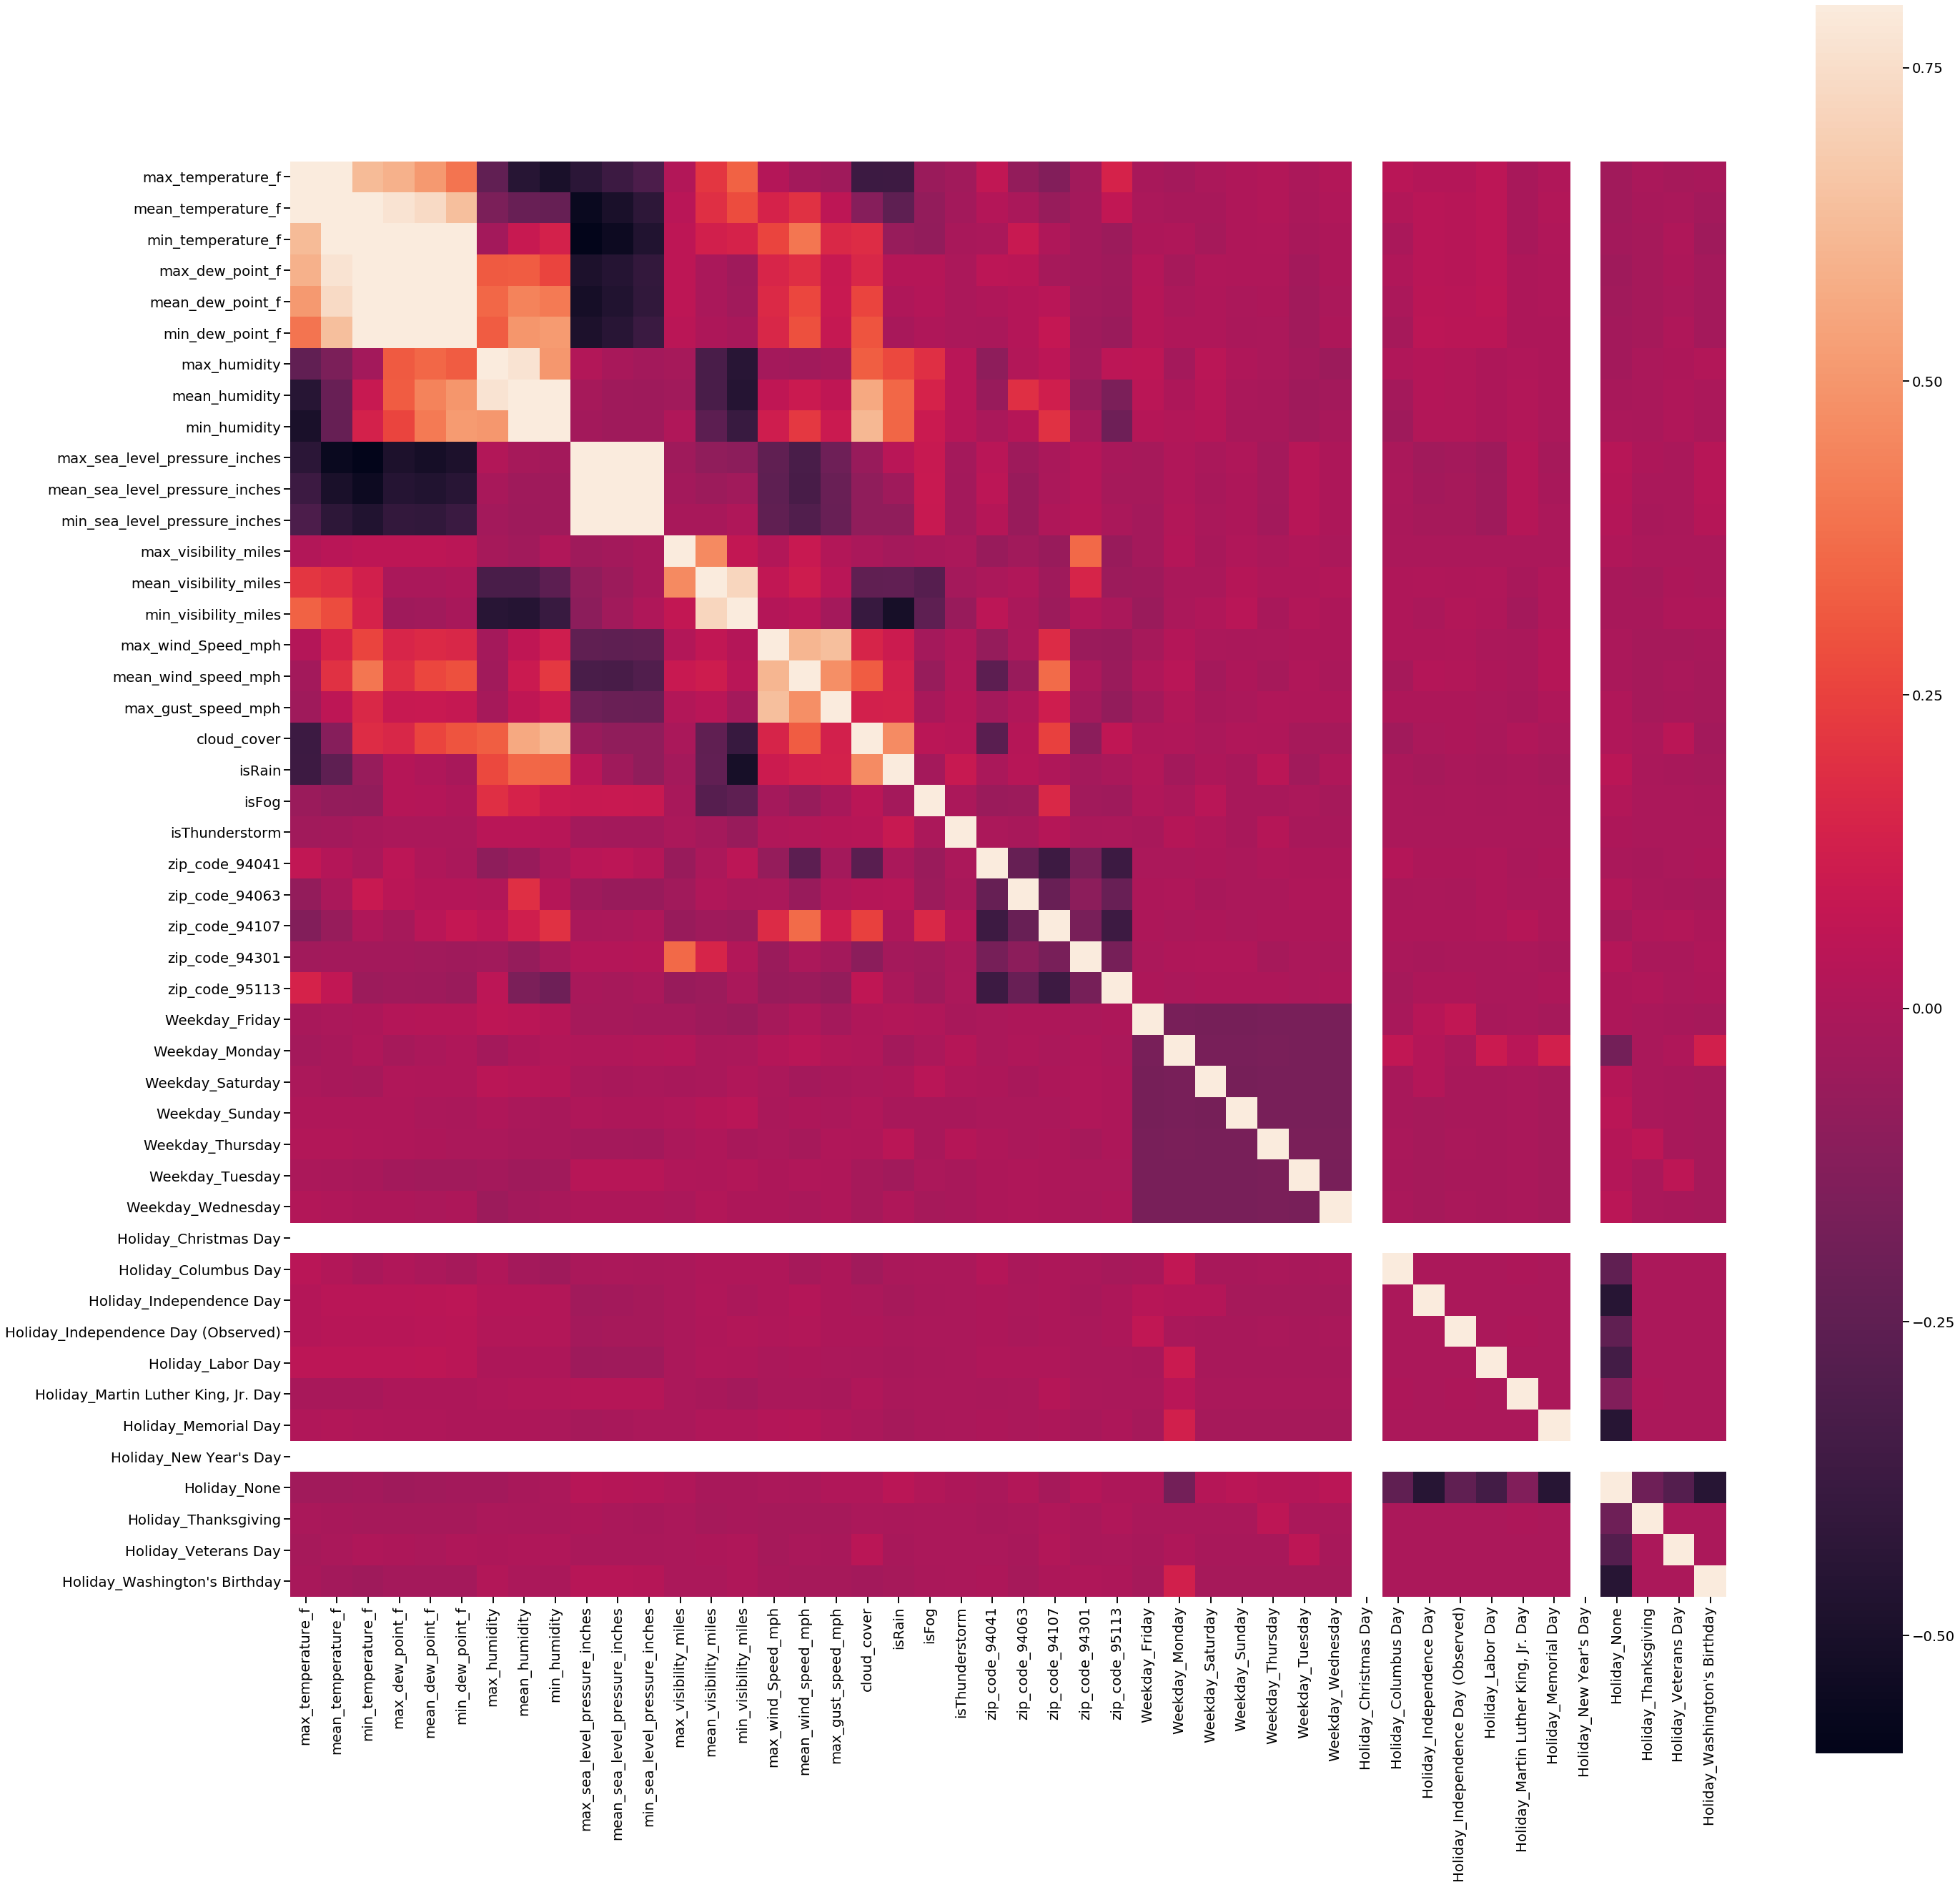

In [3]:
plt.figure(figsize=(45, 45))
sns.set_context('talk', font_scale=1.2)
sns.heatmap(X.corr(), vmax =.8, square=True)

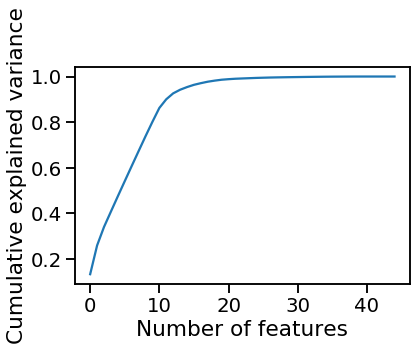

In [4]:
sns.set_context('talk', font_scale=1.2)

full_pca = PCA(n_components=45)
full_pca.fit(X)

plt.plot(np.cumsum(full_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.show()

In [5]:
pca = PCA(n_components=30)
pca_X = pd.DataFrame(pca.fit_transform(X))

print(pca_X.shape)

(3811, 30)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_X, y, test_size=0.3, random_state=50)

In [97]:
def build_keras_model_func(input, output, number_of_nodes_in_hidden_layer=3, number_of_hidden_layers=2, hidden_layer_activation='relu', output_layer_activation='linear', loss='mse'):
    def func():
        model = Sequential()
        model.add(Dense(number_of_nodes_in_hidden_layer, activation=hidden_layer_activation, input_shape=(len(input.columns),)))
        for _ in range(number_of_hidden_layers - 1):  
            model.add(Dense(number_of_nodes_in_hidden_layer, activation=hidden_layer_activation))
        model.add(Dense(1, activation=output_layer_activation))

        adam = Adam(lr=0.001)
        model.compile(loss=loss, optimizer=adam, metrics=['acc', 'mae'])
        
        return model
    
    return func

def find_outliers_isolation_forest(df):
    # find outliers using Isolation Forest
    isolation_forest = IsolationForest(contamination='auto', behaviour='new')
    isolation_forest.fit(df)
    return isolation_forest.predict(df)

def grid_search(X_train, y_train, X_test, y_test):
    # perform grid search using multiple number of layers and nodes
    grid = pd.DataFrame(index=np.arange(3), columns=np.arange(4))
    
    # 1-3 hidden layers
    for i in range(4):
        number_of_hidden_layers = i + 1

        # 3, 6, 9, or 12 nodes
        for j in range(5):
            number_of_nodes_in_hidden_layer = j * 3 + 3
            
            # create and fit model with this number of layers/nodes
            func = build_keras_model_func(X_train, y_train, number_of_nodes_in_hidden_layer=number_of_nodes_in_hidden_layer, number_of_hidden_layers=number_of_hidden_layers)
            model = func()
            model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
            
            # store testing error of model
            testing_error = model.evaluate(X_test, y_test, batch_size=32)
            grid[i][j] = 1.0 - testing_error[1]
    
    return grid

In [8]:
error_grid = grid_search(pca_X_train, pca_y_train, pca_X_test, pca_y_test)
print(error_grid)

min_error = 0
min_row = 0
min_col = 0

for row in range(len(error_grid)):
    for col in range(len(error_grid.iloc[0, :])):
        error = error_grid.iloc[row, col]
        if error < min_error:
            min_error = error
            min_row = row
            min_col = col

number_of_hidden_layers = min_row + 1
number_of_nodes_in_hidden_layer = min_col * 3 + 3

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1144/1144 [==============================] - 0s 197us/step
          0         1         2         3
0  0.993007  0.980769  0.986888  0.986888
1  0.976399  0.975524  0.984266   0.97465
2  0.980769  0.972902   0.97028  0.982517


In [13]:
func = build_keras_model_func(X_train, y_train, number_of_nodes_in_hidden_layer=number_of_nodes_in_hidden_layer, number_of_hidden_layers=number_of_hidden_layers)
reg = KerasRegressor(build_fn=func, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=1)
history = reg.fit(X_train, y_train)

Train on 2667 samples, validate on 1144 samples
Epoch 1/100
2667/2667 [==============================] - 1s 363us/step - loss: 226020.1505 - acc: 0.0240 - mae: 244.1277 - val_loss: 205876.1404 - val_acc: 0.0288 - val_mae: 231.8071
Epoch 2/100
2667/2667 [==============================] - 0s 121us/step - loss: 225978.9062 - acc: 0.0240 - mae: 244.0471 - val_loss: 205838.4856 - val_acc: 0.0288 - val_mae: 231.7305
Epoch 3/100
2667/2667 [==============================] - 0s 184us/step - loss: 225939.4765 - acc: 0.0240 - mae: 243.9714 - val_loss: 205801.4532 - val_acc: 0.0288 - val_mae: 231.6552
Epoch 4/100
2667/2667 [==============================] - 0s 114us/step - loss: 225899.8916 - acc: 0.0240 - mae: 243.8934 - val_loss: 205764.0152 - val_acc: 0.0288 - val_mae: 231.5791
Epoch 5/100
2667/2667 [==============================] - 0s 146us/step - loss: 225860.5286 - acc: 0.0240 - mae: 243.8164 - val_loss: 205726.2103 - val_acc: 0.0288 - val_mae: 231.5022
Epoch 6/100
2667/2667 [==============

Epoch 90/100
2667/2667 [==============================] - 1s 316us/step - loss: 222583.8718 - acc: 0.0202 - mae: 238.2330 - val_loss: 202617.3101 - val_acc: 0.0280 - val_mae: 225.8684
Epoch 91/100
2667/2667 [==============================] - 0s 145us/step - loss: 222546.2540 - acc: 0.0202 - mae: 238.1797 - val_loss: 202581.5951 - val_acc: 0.0280 - val_mae: 225.8167
Epoch 92/100
2667/2667 [==============================] - 0s 156us/step - loss: 222508.4948 - acc: 0.0202 - mae: 238.1285 - val_loss: 202546.5123 - val_acc: 0.0280 - val_mae: 225.7659
Epoch 93/100
2667/2667 [==============================] - 0s 142us/step - loss: 222470.8961 - acc: 0.0202 - mae: 238.0765 - val_loss: 202510.3856 - val_acc: 0.0280 - val_mae: 225.7135
Epoch 94/100
2667/2667 [==============================] - 0s 139us/step - loss: 222432.8654 - acc: 0.0202 - mae: 238.0234 - val_loss: 202474.6161 - val_acc: 0.0157 - val_mae: 225.6617
Epoch 95/100
2667/2667 [==============================] - 0s 127us/step - loss: 

In [15]:
pca_func = build_keras_model_func(pca_X_train, pca_y_train, number_of_nodes_in_hidden_layer=number_of_nodes_in_hidden_layer, number_of_hidden_layers=number_of_hidden_layers)
pca_reg = KerasRegressor(build_fn=pca_func, batch_size=32, epochs=300, validation_data=(pca_X_test, pca_y_test), verbose=1)
pca_history = pca_reg.fit(pca_X_train, pca_y_train)

Train on 2667 samples, validate on 1144 samples
Epoch 1/300
2667/2667 [==============================] - 1s 430us/step - loss: 225943.6694 - acc: 0.0232 - mae: 243.9720 - val_loss: 205746.8551 - val_acc: 0.0288 - val_mae: 231.5900
Epoch 2/300
2667/2667 [==============================] - 0s 187us/step - loss: 225751.0285 - acc: 0.0229 - mae: 243.7359 - val_loss: 205519.0118 - val_acc: 0.0253 - val_mae: 231.3204
Epoch 3/300
2667/2667 [==============================] - 0s 128us/step - loss: 225468.8343 - acc: 0.0214 - mae: 243.4319 - val_loss: 205209.2484 - val_acc: 0.0262 - val_mae: 230.9868
Epoch 4/300
2667/2667 [==============================] - 0s 137us/step - loss: 225094.7149 - acc: 0.0206 - mae: 243.0577 - val_loss: 204822.8454 - val_acc: 0.0262 - val_mae: 230.5884
Epoch 5/300
2667/2667 [==============================] - 0s 152us/step - loss: 224644.3000 - acc: 0.0225 - mae: 242.6124 - val_loss: 204360.0306 - val_acc: 0.0253 - val_mae: 230.1203
Epoch 6/300
2667/2667 [==============

Epoch 90/300
2667/2667 [==============================] - 0s 89us/step - loss: 82202.1384 - acc: 0.0075 - mae: 155.6192 - val_loss: 71945.9052 - val_acc: 0.0105 - val_mae: 145.9488
Epoch 91/300
2667/2667 [==============================] - 0s 99us/step - loss: 80528.1927 - acc: 0.0064 - mae: 154.6305 - val_loss: 70440.4079 - val_acc: 0.0061 - val_mae: 145.0586
Epoch 92/300
2667/2667 [==============================] - 0s 102us/step - loss: 78880.0413 - acc: 0.0064 - mae: 153.6656 - val_loss: 68962.4140 - val_acc: 0.0070 - val_mae: 144.1721
Epoch 93/300
2667/2667 [==============================] - 0s 106us/step - loss: 77240.4779 - acc: 0.0071 - mae: 152.7687 - val_loss: 67474.7987 - val_acc: 0.0096 - val_mae: 143.3041
Epoch 94/300
2667/2667 [==============================] - 0s 90us/step - loss: 75606.2251 - acc: 0.0082 - mae: 151.8500 - val_loss: 66008.3950 - val_acc: 0.0061 - val_mae: 142.4769
Epoch 95/300
2667/2667 [==============================] - 0s 107us/step - loss: 74021.5201 - 

Epoch 135/300
2667/2667 [==============================] - 0s 115us/step - loss: 29861.2919 - acc: 0.0052 - mae: 117.7682 - val_loss: 26267.1170 - val_acc: 0.0044 - val_mae: 111.5605
Epoch 136/300
2667/2667 [==============================] - 0s 106us/step - loss: 29242.1449 - acc: 0.0052 - mae: 116.9016 - val_loss: 25761.1495 - val_acc: 0.0035 - val_mae: 110.7613
Epoch 137/300
2667/2667 [==============================] - 0s 95us/step - loss: 28643.5492 - acc: 0.0052 - mae: 116.0775 - val_loss: 25273.2324 - val_acc: 0.0052 - val_mae: 109.9599
Epoch 138/300
2667/2667 [==============================] - 0s 89us/step - loss: 28055.3476 - acc: 0.0052 - mae: 115.2226 - val_loss: 24796.8751 - val_acc: 0.0044 - val_mae: 109.1729
Epoch 139/300
2667/2667 [==============================] - 0s 122us/step - loss: 27493.0972 - acc: 0.0052 - mae: 114.3822 - val_loss: 24341.2369 - val_acc: 0.0052 - val_mae: 108.3383
Epoch 140/300
2667/2667 [==============================] - 0s 92us/step - loss: 26951.8

2667/2667 [==============================] - 0s 109us/step - loss: 10051.7151 - acc: 0.0116 - mae: 59.3515 - val_loss: 10370.2376 - val_acc: 0.0079 - val_mae: 58.0606
Epoch 226/300
2667/2667 [==============================] - 0s 132us/step - loss: 9960.6068 - acc: 0.0082 - mae: 58.9062 - val_loss: 10288.7889 - val_acc: 0.0087 - val_mae: 57.6831
Epoch 227/300
2667/2667 [==============================] - 0s 105us/step - loss: 9871.6175 - acc: 0.0094 - mae: 58.5059 - val_loss: 10214.5677 - val_acc: 0.0079 - val_mae: 57.3463
Epoch 228/300
2667/2667 [==============================] - 0s 101us/step - loss: 9784.2292 - acc: 0.0094 - mae: 58.1125 - val_loss: 10140.3304 - val_acc: 0.0087 - val_mae: 56.9780
Epoch 229/300
2667/2667 [==============================] - 0s 108us/step - loss: 9698.1618 - acc: 0.0090 - mae: 57.7236 - val_loss: 10058.8425 - val_acc: 0.0087 - val_mae: 56.6070
Epoch 230/300
2667/2667 [==============================] - 0s 130us/step - loss: 9614.3001 - acc: 0.0082 - mae: 5

Epoch 271/300
2667/2667 [==============================] - 0s 112us/step - loss: 7132.1016 - acc: 0.0157 - mae: 44.5647 - val_loss: 7931.2569 - val_acc: 0.0122 - val_mae: 44.8845
Epoch 272/300
2667/2667 [==============================] - 0s 96us/step - loss: 7094.1152 - acc: 0.0169 - mae: 44.3240 - val_loss: 7896.0633 - val_acc: 0.0131 - val_mae: 44.6728
Epoch 273/300
2667/2667 [==============================] - 0s 96us/step - loss: 7057.2384 - acc: 0.0154 - mae: 44.1349 - val_loss: 7862.1376 - val_acc: 0.0131 - val_mae: 44.4805
Epoch 274/300
2667/2667 [==============================] - 0s 112us/step - loss: 7020.6821 - acc: 0.0184 - mae: 43.8933 - val_loss: 7830.3712 - val_acc: 0.0157 - val_mae: 44.2737
Epoch 275/300
2667/2667 [==============================] - 0s 105us/step - loss: 6984.4886 - acc: 0.0176 - mae: 43.6941 - val_loss: 7804.6225 - val_acc: 0.0140 - val_mae: 44.0808
Epoch 276/300
2667/2667 [==============================] - 0s 95us/step - loss: 6949.3297 - acc: 0.0176 - m

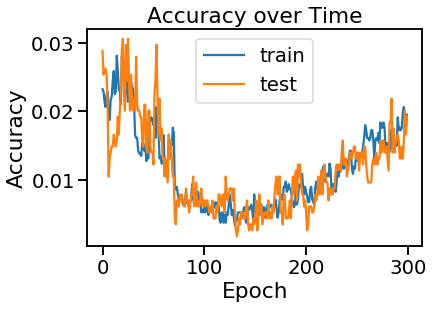

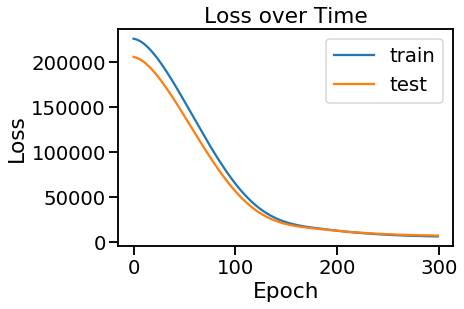

In [16]:
acc_fig, acc_ax = plt.subplots()
acc_ax.plot(pca_history.history['acc'])
acc_ax.plot(pca_history.history['val_acc'])
acc_ax.set_title('Accuracy over Time')
acc_ax.set_xlabel('Epoch')
acc_ax.set_ylabel('Accuracy')
acc_ax.legend(['train', 'test'])

loss_fig, loss_ax = plt.subplots()
loss_ax.plot(pca_history.history['loss'])
loss_ax.plot(pca_history.history['val_loss'])
loss_ax.set_title('Loss over Time')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')
loss_ax.legend(['train', 'test'])

plt.show()

In [ ]:
test_predict = pca_reg.predict(pca_X_test)
ylist = y_test["trip_count"].tolist()

for i in range(len(ylist)):
    # y actual vs y predicted
    print(str(ylist[i]), "  ", str(test_predict[i]))

c = 0
for i in range(len(ylist)):
    #print(ylist[i]-test_predict[i])
    c = c + ylist[i]-test_predict[i]
print("============")
#printing if we were short or over the amount of bikes we need
# if negative we have predicted more bikes than we actually need
print(c)
print("============")
c = 0
for i in range(len(ylist)):
    #adding up the total amount of trips taken
    c = c + ylist[i]
print("============")
print(c)
print("============")

1144/1144 [==============================] - 1s 649us/step
20    9.774528
34    9.774528
257    371.8573
17    -15.289937
4    9.774528
60    68.48249
22    33.59719
1122    1103.0067
31    74.633965
25    9.774528
28    17.422396
35    32.062828
1    9.774528
42    31.516655
7    -13.970342
80    77.42727
2    17.492012
20    9.774528
374    424.24756
45    50.02894
74    62.9573
63    81.09872
13    9.774528
33    38.722557
17    -32.256348
2    9.407851
15    9.774528
25    35.51449
5    4.8755445
56    72.79665
50    47.756493
12    -40.885235
5    -24.287556
24    61.23458
944    1009.36316
13    9.774528
797    1128.6132
22    9.774528
25    33.892487
13    9.774528
7    13.447791
43    35.88021
361    411.31976
33    9.774528
22    26.259438
9    20.916893
2    9.774528
383    407.8229
36    25.303307
39    53.48562
82    71.49584
19    9.107764
129    208.45102
1013    1039.6489
1155    1071.7833
0    9.774528
55    35.340202
279    406.56146
1086    1099.4403
1095    988.795
7

26    43.045525
54    52.061745
85    65.48084
9    2.1123877
448    466.30676
1041    1081.3278
33    -48.829727
12    9.774528
30    32.105034
377    386.66843
9    -20.119892
31    40.59542
309    337.33167
36    42.98649
22    -11.190644
1038    1001.9537
1000    985.8972
68    56.116432
7    23.661186
1056    1120.5172
6    19.143501
49    59.142937
22    9.774528
67    21.68496
0    20.092522
4    6.1661444
4    -118.08868
14    44.964256
26    30.138588
352    349.0139
84    72.77099
1    8.480567
31    9.774528
50    9.774528
36    56.054314
24    15.177115
85    72.30041
57    86.14846
17    40.109886
21    9.774528
43    46.66372
1004    1073.6813
969    910.0419
6    9.774528
17    9.774528
1194    1003.2638
5    2.8584738
24    9.774528
2    -1.8238764
34    39.89257
10    -16.503105
12    9.774528
70    78.727135
42    73.35754
46    41.172295
38    44.228508
54    47.31585
4    13.912665
63    38.884743
278    390.06573
11    0.885087
45    58.107933
31    35.821007
3    

In [ ]:
perm = PermutationImportance(reg, random_state=32).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

In [ ]:
entries_94107 = time_series_data[time_series_data["zip_code_94107"] == 1]
entries_94041 = time_series_data[time_series_data["zip_code_94041"] == 1]
entries_95113 = time_series_data[time_series_data["zip_code_95113"] == 1]
entries_94063 = time_series_data[time_series_data["zip_code_94063"] == 1]
entries_94301 = time_series_data[time_series_data["zip_code_94301"] == 1]

In [ ]:
# Ordinary Least Squares (TODO)

In [ ]:
# LSTM (TODO)